In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [13]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Capstone_Project/telecomchurndata.csv"
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Display basic information about the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerID       19 non-null     object 
 1   Gender           19 non-null     object 
 2   Tenure           19 non-null     int64  
 3   InternetService  19 non-null     object 
 4   Contract         19 non-null     object 
 5   PaymentMethod    19 non-null     object 
 6   MonthlyCharges   19 non-null     float64
 7   TotalCharges     19 non-null     float64
 8   Churn            19 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.5+ KB


In [15]:
# Show first few rows
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   customerID  Gender  Tenure InternetService        Contract  \
0  7590-VHVEG  Female       1             DSL  Month-to-month   
1  5575-GNVDE    Male      34             DSL        One year   
2  3668-QPYBK    Male       2             DSL  Month-to-month   
3  7795-CFOCW    Male      45             DSL        One year   
4  9237-HQITU  Female       2     Fiber optic  Month-to-month   

               PaymentMethod  MonthlyCharges  TotalCharges Churn  
0           Electronic check           29.85         29.85    No  
1               Mailed check           56.95       1889.50    No  
2               Mailed check           53.85        108.15   Yes  
3  Bank transfer (automatic)           42.30       1840.75    No  
4           Electronic check           70.70        151.65   Yes  


In [16]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])


Missing Values:
Series([], dtype: int64)


In [17]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
          Tenure  MonthlyCharges  TotalCharges
count  19.000000       19.000000     19.000000
mean   30.368421       68.807895   2356.426316
std    23.995857       32.700549   2482.866909
min     1.000000       18.950000     29.850000
25%    10.000000       46.125000    427.575000
50%    25.000000       56.950000   1840.750000
75%    50.500000      102.025000   3267.000000
max    71.000000      113.250000   7895.150000


In [18]:

# Tag churners: Convert 'Churn' column to numerical values (Yes -> 1, No -> 0)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


In [19]:
# Check for data imbalance
churn_counts = df["Churn"].value_counts()
print("\nChurn Value Counts:")
print(churn_counts)


Churn Value Counts:
Churn
0    13
1     6
Name: count, dtype: int64


<ipython-input-20-ff09b10408a0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=["blue", "red"])


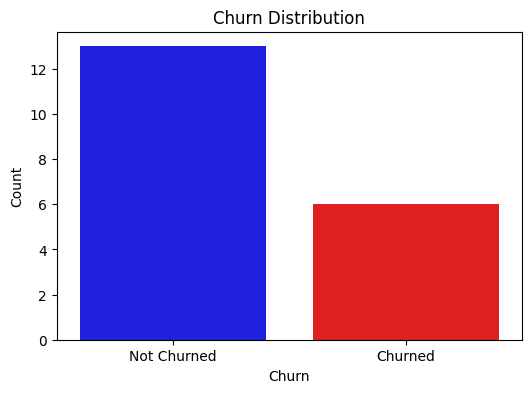

In [20]:
# Visualize churn distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=["blue", "red"])
plt.xticks([0, 1], ['Not Churned', 'Churned'])
plt.xlabel("Churn")
plt.ylabel("Count")
plt.title("Churn Distribution")
plt.show()

In [21]:
# Calculate the 70th percentile of MonthlyCharges to filter high-value customers
threshold = df["MonthlyCharges"].quantile(0.70)
high_value_customers = df[df["MonthlyCharges"] >= threshold]

In [22]:
print(f"\nMonthly Charges 70th percentile threshold: {threshold}")
print(f"Number of high-value customers: {high_value_customers.shape[0]}")


Monthly Charges 70th percentile threshold: 100.07
Number of high-value customers: 6


In [51]:
# Drop non-essential columns
columns_to_drop = ["customerID"]
processed_df = high_value_customers.drop(columns=columns_to_drop)
processed_df = high_value_customers.drop(columns=columns_to_drop, errors="ignore")
print(processed_df.columns)

Index(['Gender', 'Tenure', 'InternetService', 'Contract', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [52]:
# Feature Engineering: Create tenure groups
if "Tenure" in processed_df.columns:
    processed_df["Tenure"] = pd.to_numeric(processed_df["Tenure"], errors="coerce")
    processed_df["Tenure"].fillna(0, inplace=True)
else:
    print("⚠️ 'tenure' column not found! Please check your dataset.")






<ipython-input-52-eeea994310f9>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df["Tenure"].fillna(0, inplace=True)


In [61]:
if "Tenure" in processed_df.columns:
    processed_df["tenure_group"] = pd.cut(
        processed_df["Tenure"],
        bins=[0, 12, 24, 36, 48, 60, np.inf],
        labels=["0-1 yr", "1-2 yrs", "2-3 yrs", "3-4 yrs", "4-5 yrs", "5+ yrs"]
    )
    print("✅ 'tenure_group' successfully created.")
else:
    print("⚠️ 'tenure' column is missing, cannot create 'tenure_group'")

✅ 'tenure_group' successfully created.


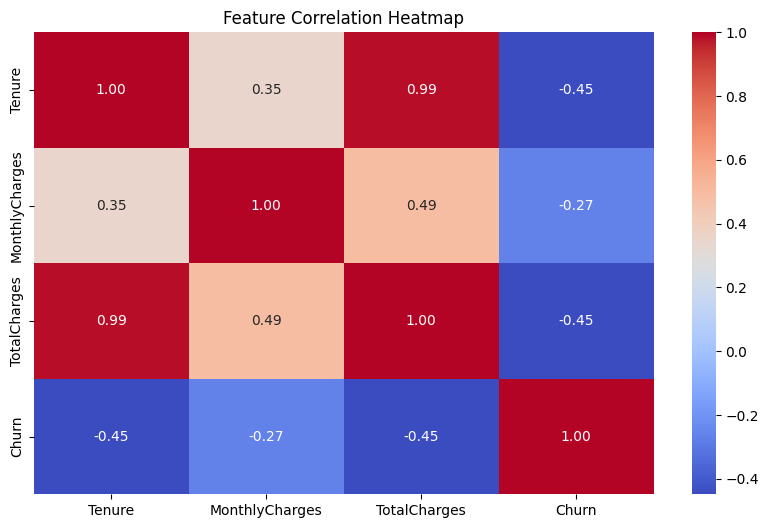

In [62]:
# Correlation heatmap
# Select only numeric columns
numeric_cols = processed_df.select_dtypes(include=[np.number])

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [63]:
# Data Preprocessing
categorical_features = ["tenure_group", "Contract", "PaymentMethod", "InternetService"]
numerical_features = ["Tenure", "MonthlyCharges", "TotalCharges"]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [64]:
# Data Preprocessing
categorical_features = ["tenure_group", "Contract", "PaymentMethod", "InternetService"]
numerical_features = ["Tenure", "MonthlyCharges", "TotalCharges"]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [65]:
print(processed_df.columns)


Index(['Gender', 'Tenure', 'InternetService', 'Contract', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'tenure_group'],
      dtype='object')


In [66]:
print(X_train.columns)


Index(['Gender', 'Tenure', 'InternetService', 'Contract', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


In [67]:
# Split dataset
X = processed_df.drop("Churn", axis=1)
y = processed_df["Churn"]
X = processed_df.drop(columns=["Churn"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
# Model Training
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


Model: Logistic Regression
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: Random Forest
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
